#### **LangGraph WorkFlows**

In [36]:
# Installing required libraries
import os
from langgraph.graph import Graph,StateGraph,END
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain.prompts import PromptTemplate,ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough,RunnableParallel,RunnableLambda
from langchain_chroma import Chroma
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from pydantic import BaseModel , Field
from langchain.output_parsers import PydanticOutputParser
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage
from dotenv import load_dotenv
load_dotenv()

True

##### Workflow 1 : Simple Workflow

In [11]:
def function1(input1):
    return "from function1: "+input1 + " "

def function2(input2):
    return input2 + "from function2"

# initializing the Graph workflow
workflow1 = Graph()

# adding nodes into the workflow
workflow1.add_node("function1",function1)
workflow1.add_node("function2",function2)

# adding edge between two nodes --> Pass the output of node1 to node2
workflow1.add_edge("function1","function2")

# setting the entry point for the workflow
workflow1.set_entry_point("function1")

# setting the finish point for the workflow
workflow1.set_finish_point("function2")

# compiling the complete workflow
app1 = workflow1.compile()
# print(app1)

# Invoking the workflow with the .invoke() function
result = app1.invoke("Hi Hrishikesh here")
# print(result)

# Streaming the input to the function
for output in app1.stream("Hrishikesh"):
    for key,value in output.items():
        print(f"Here is output from {key}")
        print("-----------")
        
        print(value)
        print("\n")

Here is output from function1
-----------
from function1: Hrishikesh 


Here is output from function2
-----------
from function1: Hrishikesh from function2




##### Workflow2 : External function + simple workflow

In [21]:
# Keeping third function outside of workflow
def function3(input3):
    return f"Called by function2  {input3}"

In [23]:
def function1(input1):
    return "Hi from function1 "+input1 + " "

def function2(input2):
    out_func_3 = function3(input2)
    return "Calling function 3, " + out_func_3 

# initializing the Graph workflow
workflow2 = Graph()

# adding nodes into the workflow
workflow2.add_node("function1",function1)
workflow2.add_node("function2",function2)

# adding edge between two nodes --> Pass the output of node1 to node2
workflow2.add_edge("function1","function2")

# setting the entry point for the workflow
workflow2.set_entry_point("function1")

# setting the finish point for the workflow
workflow2.set_finish_point("function2")

# compiling the complete workflow
app2 = workflow2.compile()
# print(app1)

# Invoking the workflow with the .invoke() function
result = app2.invoke("Hi Hrishikesh here")
# print(result)

# Streaming the input to the function
for output in app2.stream("Hrishikesh"):
    for key,value in output.items():
        print(f"Here is output from {key}")
        print("-----------")
        
        print(value)
        print("\n")

Here is output from function1
-----------
Hi from function1 Hrishikesh 


Here is output from function2
-----------
Calling function 3, Called by function2  Hi from function1 Hrishikesh 




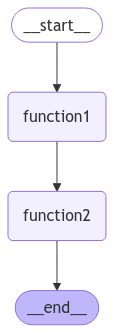

In [24]:
# checking the graph after calling external function "function3"
app2

##### Workflow3: LLM + Simple Workflow

In [34]:
# Initializing the LLM model
llm = ChatGroq(model="llama-3.3-70b-versatile",temperature=0)

# Defining the 1st function
def function1(input):
    result = llm.invoke(input)
    return result

# Defining the 2nd function
def ToUpper(input):
    return input.content.upper()

# Initializing workflow
workflow3 = Graph()

# Creating the nodes
workflow3.add_node("LLM",function1)
workflow3.add_node("ToUpper",ToUpper)

# Creating edges
workflow3.add_edge("LLM","ToUpper")

# Defining start point and finish point
workflow3.set_entry_point("LLM")
workflow3.set_finish_point("ToUpper")

# Compiling the workflow
app3 = workflow3.compile()
print(app3)

# getting the response from workflow
response = app3.invoke("Current precident of India")
print(response)

THE CURRENT PRESIDENT OF INDIA IS DROUPADI MURMU. SHE TOOK OFFICE ON JULY 25, 2022, AND IS THE 15TH PRESIDENT OF INDIA. PRIOR TO HER PRESIDENCY, SHE SERVED AS THE GOVERNOR OF JHARKHAND FROM 2015 TO 2021.


##### Workflow4: LLM + Token Counter

In [38]:
# Initializing the LLM model
llm = ChatGroq(model="llama-3.3-70b-versatile",temperature=0)

# Defining the 1st function
def get_response(input):
    result = llm.invoke(input)
    return result

# Defining the 2nd function
def count_tokens(input):
    tokens_lst = input.content.split()
    return f"Total tokens return : {len(tokens_lst)}"

# Initializing workflow
workflow4 = Graph()

# Creating the nodes
workflow4.add_node("LLM",function1)
workflow4.add_node("Count Tokens",count_tokens)

# Creating edges
workflow4.add_edge("LLM","Count Tokens")

# Defining start point and finish point
workflow4.set_entry_point("LLM")
workflow4.set_finish_point("Count Tokens")

# Compiling the workflow
app4 = workflow4.compile()
# print(app4)

# getting the response from workflow
response = app4.invoke("Rohit Sharama 200")
print(response)

Total tokens return : 154


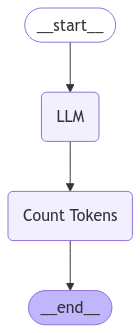

In [39]:
app4

##### Workflow 5: LLM + RAG

In [53]:
os.chdir("E:/Programming/Projects/LLM/Agents")

In [54]:
# Defining LLM model and Huggingface Embeddings
llm = ChatGroq(model="llama-3.3-70b-versatile",temperature=0)
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [57]:
# Loading the articles from data folder
loader = TextLoader(file_path="data/article.txt")
document = loader.load()

# Chunking the document into multiple chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=100,chunk_overlap=30)
docs = text_splitter.split_documents(document)

In [58]:
# Storing the embeddings and chunks inside vector database
db = Chroma.from_documents(documents=docs,embedding=embeddings)
retriever = db.as_retriever(search_kwargs={"k":3})

In [64]:
# Creating functions which works as nodes

# Function1 
def function1(AgentState:dict)->dict:
    message = AgentState["messages"]
    question = message[-1]
    
    complete_prompt="Your task is to provide only the brief answer based on the user query. \
        Don't include too much reasoning. Following is the user query: " + question
        
    response = llm.invoke(complete_prompt)
    AgentState['messages'].append(response.content)
    return AgentState


# Function2 : Rag
def function2(AgentState):
    messages = AgentState["messages"]
    
    question = messages[0]
    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = PromptTemplate.from_template(template=template)
    
    retrieval_chain = (
        {"context":retriever,"question":RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )
    result =retrieval_chain.invoke(question)
    return result

In [68]:
workflow5 = Graph()
workflow5.add_node("LLM",function1)
workflow5.add_node("RAGTool",function2)

workflow5.add_edge(start_key="LLM",end_key="RAGTool")
workflow5.set_entry_point("LLM")
workflow5.set_finish_point("RAGTool")

app5 = workflow5.compile()
# app5

In [69]:
# Invoking the workflow to get response back
app5.invoke({"messages":["What is langgraph"]})

# Use stream to get the answer
input = {"messages":["What is langgraph"]}
for output in app5.stream(input):
    for key,value in output.items():
        print(f"Output from node : {key}")
        print("-------------------")
        print(value)
    print("\n\n")

Output from node : LLM
-------------------
{'messages': ['What is langgraph', 'LangGraph is an open-source, large language model developed by Meta AI.']}



Output from node : RAGTool
-------------------
LangGraph is an open-source library developed by LangChain Inc. designed to facilitate the creation.





##### Workflow6 : LLM + RAG + Router

In [7]:
os.chdir("E:/Programming/Projects/LLM/Agents")

In [8]:
# Defining LLM model and Huggingface Embeddings
llm = ChatGroq(model="llama-3.3-70b-versatile",temperature=0)
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [9]:
# Loading the articles from data folder
loader = TextLoader(file_path="data/Indian_industrial_revolution.txt")
document = loader.load()

# Chunking the document into multiple chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=100,chunk_overlap=30)
docs = text_splitter.split_documents(document)

In [10]:
# Storing the embeddings and chunks inside vector database
db = Chroma.from_documents(documents=docs,embedding=embeddings)
retriever = db.as_retriever(search_kwargs={"k":3})

In [11]:
query = "Tell me about India's Industrial Growth?"
docs = retriever.get_relevant_documents(query)
print(docs[0].metadata)
print(docs[0].page_content)

for doc in docs:
    print(doc)

C:\Users\admin\AppData\Local\Temp\ipykernel_5040\2839617881.py:2: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(query)


{'source': 'data/Indian_industrial_revolution.txt'}
evolution, colonial legacy, and modern economic progress. India's journey to industrialization
page_content='evolution, colonial legacy, and modern economic progress. India's journey to industrialization' metadata={'source': 'data/Indian_industrial_revolution.txt'}
page_content='The 21st Century: India’s Modern Industrial Revolution' metadata={'source': 'data/Indian_industrial_revolution.txt'}
page_content='The Indian Industrial Revolution: A Catalyst for Economic Transformation' metadata={'source': 'data/Indian_industrial_revolution.txt'}


**TypedDict:**
TypedDict is a special type that allows you to define a dictionary in Python where each key has a specific type. It’s useful when you want to enforce type checks on the keys and values of a dictionary.

**Annotated:**
Annotated is used to add metadata or constraints to a type. It’s typically used for adding additional information, like constraints or descriptions, to the type.

**Sequence[BaseMessage]:**
Sequence is a generic type from Python's typing module that represents a list-like structure (such as a list or tuple) where the order matters, and you can access elements by their position.

**BaseMessage:**
Basemessage: This assumes you're working with the LangChain framework, and BaseMessage is part of its core messaging system. It is typically used when handling or processing messages in LangChain's workflows

**operator.add:**
operator.add is a function from Python’s operator module that performs addition (+) on its arguments. In this context, operator.add is being used as metadata for the Annotated type, likely suggesting that the sequence of BaseMessage objects is meant to be "added" or concatenated with another sequence at some point. It’s an indicator of how the messages field will be treated in the logic of your program.

**TopicSelectionParser:** A Pydantic model that defines two fields (Topic and Reasoning), both of which are required to be strings.

**Field:** Adds metadata, like descriptions, and can also be used for validation and constraints.

**Pydantic’s Role:** Ensures that the data matches the expected structure and types, raising validation errors if the data is invalid.

**Putting It All Together:**

- The line messages: Annotated[Sequence[BaseMessage], operator.add] defines a field messages that:

- Must be a sequence (like a list or tuple) of BaseMessage objects. Has the additional annotation operator.add, which suggests that this sequence is intended to support addition (i.e., concatenation of multiple sequences of messages).

**messages:** Annotated[Sequence[BaseMessage], operator.add]

**"messages":** [BaseMessage("Hello!", "Alice"), BaseMessage("Hi!", "Bob")]

In [41]:
class AgentState(TypedDict):
    # The 'messages' field should be a sequence of strings, and we annotate it with 'operator.add'
    # This implies we might want to "add" new messages to the sequence later
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [42]:
class TopicSelectionParser(BaseModel):
    Topic: str = Field(description='Selected Topic')
    Reasoning: str = Field(description='Reasoning behind topic selection')

In [43]:
parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [44]:
print(parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"Topic": {"description": "Selected Topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}
```


In [57]:
def function_1(state):
    message=state["messages"]
    question=message[-1]
    print(question)
    
    template="""
    Your task is to classify the given user query into one of the following categories: [Related to India,Not related to India]. 
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """
    
    prompt = PromptTemplate(template=template,
                                    input_variables=[question],
                                    partial_variables={
                                        "format_instructions" : parser.get_format_instructions()                                    }
                                    )
    chain =  (prompt | llm | parser)
    
    response = chain.invoke({"question":question,"format_instructions" : parser.get_format_instructions() })

    print(response)

    return {"messages": [response.Topic]}

In [58]:
state={"messages": ["Eiffel Tower"]}
function_1(state)

Eiffel Tower
Topic='Not related to India' Reasoning='The Eiffel Tower is a famous landmark located in Paris, France, and has no direct relation to India.'


{'messages': ['Not related to India']}

In [47]:
def function_2(state):
    print('-> Calling RAG ->')
    messages = state['messages']
    question = messages[0] ## Fetching the user question
    print(question)

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)
    
    print(prompt)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return  {"messages": [result]}

In [60]:
function_2({"messages":["India"]})

-> Calling RAG ->
India
input_variables=['context', 'question'] input_types={} partial_variables={} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='Answer the question based only on the following context:\n    {context}\n\n    Question: {question}\n    '), additional_kwargs={})]


{'messages': ["India's position as a global industrial leader. India's journey to industrialization. an emphasis on research and development will further solidify India’s position as a global"]}

In [49]:
def function_3(state):
    print('-> Calling LLM ->')

    messages = state['messages']
    question = messages[0] ## Fetching the user question

    # Normal LLM call
    complete_query = "Anwer the follow question with your knowledge of the real world. Following is the user question: " + question
    response = llm.invoke(complete_query)
    return {"messages": [response.content]}

In [ ]:
function_3

In [67]:
def router(state):
    print('-> Router ->')
    
    messages = state["messages"]
    last_message = messages[-1]
    print(f"Last Message : {last_message}")
    if last_message == 'Related to India':
        return 'Calling RAG'
    elif last_message == 'Not related to India':
        return 'Calling LLM'
    else:
        print('Unexpected classification result:', last_message)
        # Handle unexpected result

In [68]:
workflow6 = StateGraph(AgentState) ### StateGraph with AgentState
workflow6.add_node("agent", function_1)
workflow6.add_node("RAG", function_2)
workflow6.add_node("LLM", function_3)
workflow6.set_entry_point("agent")

workflow6.add_conditional_edges(
    "agent",
    router,
    {
        "Calling RAG": "RAG",
        "Calling LLM": "LLM",
    }
)

workflow6.add_edge("RAG",END)
workflow6.add_edge("LLM",END)
app6=workflow6.compile()

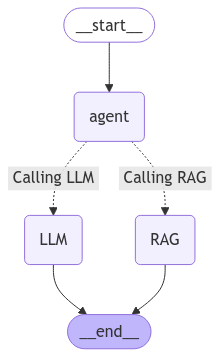

In [69]:
app6

In [71]:
inputs = {"messages": ["Steve Smith"]}
app6.invoke(inputs)

Steve Smith
Topic='Not related to India' Reasoning="The query 'Steve Smith' refers to an Australian cricketer, with no direct relation to India."
-> Router ->
Last Message : Not related to India
-> Calling LLM ->


{'messages': ['Steve Smith',
  'Not related to India',
  "There are several notable individuals named Steve Smith, so it's possible that you're referring to one of the following:\n\n1. Steve Smith (cricketer): An Australian international cricketer who has played for the Australian national team as a batsman. He is widely regarded as one of the best batsmen in the world.\n2. Steve Smith (American football): A former American football wide receiver who played in the National Football League (NFL) for several teams, including the Carolina Panthers and Baltimore Ravens.\n3. Steve Smith (musician): An American drummer who has played with several bands, including Journey and Vital Information.\n4. Steve Smith (basketball): An American former professional basketball player who played in the NBA for several teams, including the Miami Heat and San Antonio Spurs.\n\nWithout more context, it's difficult to determine which Steve Smith you are referring to. If you could provide more information or 